In [1]:
is_skip = True

# Data params
batch_size = 128
# batch_size = 16
pred_len = 30

# Model params
d_model = 64
nhead = 2
d_ff = 128
dropout = 0.1
num_layers = 2

# Import

In [2]:
import os
import joblib
import copy
import time
import math

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
from skimage import io

device = torch.device("cuda:0")
# device = torch.device("cpu")
tqdm.pandas()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

In [4]:
def preprocess(data):
    data = data.copy()

    # Image path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=10)]

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])
    
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=pred_len*2)]
    data["time_idx"] = data.groupby("article_id").cumcount()
    data["time_idx"] = data["size"] - data["time_idx"]

    # Make holidays
    holiday = holidays.US()
    data["holiday"] = data["t_dat"].apply(lambda x: 1 if x in holiday else 0)

    # Temporal information
    # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year / (data["t_dat"].dt.year.max() + 1)

    # Append meta data
    data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "product_type_name"]], on="article_id")

    # Split
    df_train = data[data["time_idx"] > 30].copy()
    df_train["time_idx"] = df_train["time_idx"] - 30
    df_valid = data.copy()

    # Output
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True)

if not is_skip:
    df_prep = df_trans.copy()#.iloc[:1000]
    df_train, df_valid = preprocess(df_prep)
    
    df_train.to_parquet("df_train.pq")
    df_valid.to_parquet("df_valid.pq")

### Dataset

In [5]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)
    
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return x

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")
# mask_value = 999

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, is_train=True):
        # Define parameters
        self.is_train = is_train
        
        # Iterate each product
        self.data_li = []
        self.min_val, self.max_val = data["sales"].min(), data["sales"].max()
        data.groupby("article_id").progress_apply(lambda x: self.data_li.append(x))

    def __len__(self):
        return len(self.data_li)
    
    def __getitem__(self, idx):
        # Obtain information about data for each
        data = self.data_li[idx]

        # Name each and scale data
        sales_scaler, price_scaler = LogScaler(), NoneScaler() # ---------------------------------------------------------------------
        ## Sales information
        sales = sales_scaler.fit_transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        y = sales_scaler.transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        ## Temporal information
        dow = data["dow"].values
        month = data["month"].values
        holiday = data["holiday"].values
        price = price_scaler.fit_transform(data["price"].values.reshape(-1,1)).reshape(-1)

        # Generate mask: 0 for valid, 1 for mask(, replacement, real), 2 for padding
        if self.is_train:
            # When training, mask random time steps
            sales, mask, y_cat = self.generate_mask(sales, sales_scaler)
        else:
            # When validating, encode first 60 time steps and predict successive 30 time steps
            sales, mask, start_idx, end_idx, y_cat = self.generate_valid_mask(sales, sales_scaler)
            dow = dow[start_idx:end_idx]
            month = month[start_idx:end_idx]
            holiday = holiday[start_idx:end_idx]
            price = price[start_idx:end_idx]
            y = y[start_idx:end_idx]
            y_cat = y_cat[start_idx:end_idx]
        return {"sales": torch.Tensor(sales), 
                "dow":torch.IntTensor(dow), "month":torch.IntTensor(month), "holiday":torch.IntTensor(holiday), "price":torch.Tensor(price), 
                "mask":torch.Tensor(mask), "length": len(y),
                "y":torch.Tensor(y), "y_cat":torch.IntTensor(y_cat)}
        
    def generate_mask(self, data, scaler):
        index = np.arange(len(data)) # Index for each time step
        num_masks = int(len(data) * 0.8) # Amont of masked values------------------------------------
        candidate_idx = np.random.choice(index, num_masks, replace=False) # Indexes to be masked
        assert num_masks == len(candidate_idx), "Not enough masks"
        
        # Generate mask: 0 for valid, 1 for mask(, replacement, real), 2 for padding
        mask, y_cat = [], []
        for i in index:
            if i in candidate_idx:
                if np.random.rand() < 0.5: # Mask with 80% probability
                    data[i] = -99
                    mask.append(1)
                    y_cat.append(0) # Flag for masking
                
                elif np.random.rand() < 0.5: # Replce with random values with 10% probability
                    random_val = np.random.randint(self.min_val, self.max_val) # Extract random value within min and max value from the whole datset
                    random_val = scaler.transform([[random_val]]).reshape(-1) # Scale the value since the min max is from those which is not scaled
                    data[i] = random_val
                    mask.append(1)
                    y_cat.append(1) # Flag for random replacement
                
                else: # Leave it as it is with 10% probability
                    mask.append(1) 
                    y_cat.append(2) # Flag for real value
            else:
                mask.append(0)
                y_cat.append(2) # Not going to be used for calculating classification loss (The loss is calculated for 1 from mask(list obj) only)
        assert len(mask) == len(data) == len(y_cat)
        return data, mask, y_cat

    def generate_valid_mask(self, data, scaler):
        start_idx = 0
        end_idx = 90

        data = data[start_idx:end_idx]
        y_cat = np.zeros(len(data)) + 1
        data[-20:] = -99 # Mask last 30 time steps
        
        mask = np.zeros(len(data))
        mask[-20:] = 1
        y_cat[-20:] = 0

        assert len(mask) == len(y_cat) == len(data)

        return data, mask, start_idx, end_idx, y_cat

def collate_fn(batch_li):
    # Get data
    sales = [batch["sales"] for batch in batch_li]
    dow = [batch["dow"] for batch in batch_li]
    month = [batch["month"] for batch in batch_li]
    holiday = [batch["holiday"] for batch in batch_li]
    price = [batch["price"] for batch in batch_li]
    mask = [batch["mask"] for batch in batch_li]
    length = [batch["length"] for batch in batch_li]
    y = [batch["y"] for batch in batch_li]
    y_cat = [batch["y_cat"] for batch in batch_li]

    # Pad data
    # We determine whether each position is valid or mask or padding with only `mask`.
    # Therefore, padding value for others are irrelavent but matters only for `mask`
    sales = torch.nn.utils.rnn.pad_sequence(sales, batch_first=True)
    dow = torch.nn.utils.rnn.pad_sequence(dow, batch_first=True)
    month = torch.nn.utils.rnn.pad_sequence(month, batch_first=True)
    holiday = torch.nn.utils.rnn.pad_sequence(holiday, batch_first=True)
    price = torch.nn.utils.rnn.pad_sequence(price, batch_first=True)
    mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True, padding_value=2)
    y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True)
    y_cat = torch.nn.utils.rnn.pad_sequence(y_cat, batch_first=True)
    
    return {"sales": sales, 
            "dow":dow, "month":month, "holiday":holiday, "price":price, 
            "mask":mask, "length": torch.IntTensor(length),
            "y":y, "y_cat":y_cat}

train_dataset = Dataset(df_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, is_train=False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for data in train_dataloader:
    print("sales:", data["sales"].shape)
    print("price:", data["price"].shape)
    print("dow:", data["dow"].shape)
    print("mask:", data["mask"].shape)
    print("y:", data["y"].shape)
    print("y_cat:", data["y_cat"].shape)
    print("length:", data["length"].shape)
    break

100%|██████████| 75048/75048 [00:02<00:00, 28131.04it/s]


sales: torch.Size([128, 704])
price: torch.Size([128, 704])
dow: torch.Size([128, 704])
mask: torch.Size([128, 704])
y: torch.Size([128, 704])
y_cat: torch.Size([128, 704])
length: torch.Size([128])


In [7]:
sales = data["sales"][-1]
length = data["length"][-1]
y_cat = data["y_cat"][-1]

print(sales[:length])
y_cat


tensor([-99.0000, -99.0000, -99.0000, -99.0000, -99.0000,   6.1633, -99.0000,
        -99.0000, -99.0000, -99.0000, -99.0000, -99.0000, -99.0000,   6.9088,
        -99.0000,   0.0000,   7.5213, -99.0000, -99.0000,   0.0000,   7.5807,
        -99.0000,   0.0000, -99.0000, -99.0000,   4.2195,   7.3505,   4.9558,
          0.0000,   6.3190,   0.0000,   7.1515, -99.0000,   0.6931, -99.0000,
          0.0000, -99.0000,   7.8399,   0.0000, -99.0000, -99.0000, -99.0000,
          7.5668, -99.0000, -99.0000,   0.0000, -99.0000,   5.9839,   0.0000,
        -99.0000, -99.0000, -99.0000,   0.0000,   7.6695, -99.0000,   0.0000,
        -99.0000, -99.0000,   0.0000,   0.0000, -99.0000, -99.0000,   0.0000,
          0.0000, -99.0000,   0.6931, -99.0000,   7.3582, -99.0000,   0.0000,
          6.7310, -99.0000,   7.7613,   7.1585,   0.0000, -99.0000, -99.0000,
        -99.0000, -99.0000,   6.8586, -99.0000, -99.0000, -99.0000,   7.0605,
          0.0000,   6.9489, -99.0000, -99.0000,   3.0445, -99.00

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 1, 0, 2, 0,
        0, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1,
        2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0,
        1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1,
        0, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2,
        0, 2, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0,
        0, 2, 1, 0, 0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1,
        0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 2, 0,
        1, 0, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
# for data in valid_dataloader:
#     print("sales:", data["sales"].shape)
#     print("price:", data["price"].shape)
#     print("mask:", data["mask"].shape)
#     print("y:", data["y"].shape)
#     print("length:", data["length"].shape)
#     break

# Architecture

### Helper

In [9]:
from torch.nn import functional as F

def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class PositionalEncoding(torch.nn.Module):
    # PE(pos, 2i) = sin(pos/10000^{2i/d_model}), 
    # PE(pos, 2i+1) = cos(pos/10000^{2i/d_model})
    def __init__(self, max_len, d_model, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

        position = torch.arange(max_len).reshape(-1,1).to(device)
        i = torch.arange(d_model).to(device)//2
        exp_term = 2*i/d_model
        div_term = torch.pow(10000, exp_term).reshape(1, -1)
        self.pos_encoded = position / div_term

        self.pos_encoded[:, 0::2] = torch.sin(self.pos_encoded[:, 0::2])
        self.pos_encoded[:, 1::2] = torch.cos(self.pos_encoded[:, 1::2])

    def forward(self, x):
        output = x + self.pos_encoded[:x.shape[1], :]
        return self.dropout(output)

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)

class DecoderLayer(torch.nn.TransformerDecoderLayer):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
        x = tgt
        if self.norm_first: raise
        else:
            self_attn_output, self_attn_weight = self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal)
            x = self.norm1(x + self_attn_output)

            cross_attn_output, cross_attn_weight = self._mha_block(x, memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = self.norm2(x + cross_attn_output)
            x = self.norm3(x + self._ff_block(x))
        return x, self_attn_weight, cross_attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, self_attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=True, average_attn_weights=False)
        return self.dropout1(x), self_attn_weight

    # multihead attention block
    def _mha_block(self, x, mem, attn_mask, key_padding_mask, is_causal=False):
        x, cross_attn_weight = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=True, average_attn_weights=False)
        return self.dropout2(x), cross_attn_weight

class Decoder(torch.nn.TransformerDecoder):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
        output = tgt

        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for n, mod in enumerate(self.layers):
            output, self_attn_weight, cross_attn_weight = mod(output, memory, tgt_mask=tgt_mask,
                                                            memory_mask=memory_mask,
                                                            tgt_key_padding_mask=tgt_key_padding_mask,
                                                            memory_key_padding_mask=memory_key_padding_mask,
                                                            tgt_is_causal=tgt_is_causal,
                                                            memory_is_causal=memory_is_causal)

        if self.norm is not None:
            output = self.norm(output)

        return output, self_attn_weight, cross_attn_weight

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        attn_output, attn_weight = self._sa_block(x, src_mask, src_key_padding_mask, is_causal=is_causal)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self._ff_block(x))

        return x, attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal, average_attn_weights=False)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, mask=None, src_key_padding_mask=None, is_causal=None):
       ################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ################################################################################################################

        for mod in self.layers:
            output, attn_weight = mod(output, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

### Transformer

In [10]:
class TemporalBlockEncoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation="relu"):
        super().__init__()
        self.d_model = d_model
        
        self.Q_linear = torch.nn.Linear(d_model, d_model)
        self.K_linear = torch.nn.Linear(d_model, d_model)
        self.V_linear = torch.nn.Linear(d_model, d_model)

        self.attn_dropout = torch.nn.Dropout(dropout)
        self.attn_linear = torch.nn.Linear(d_model, d_model)

        self.dropout1 = torch.nn.Dropout(dropout)
        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.feedforward = FeedForward(d_model, d_ff, activation)

        self.dropout2 = torch.nn.Dropout(dropout)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
    
    def forward(self, src, padding_mask=None):
        attn_output, attn_weight = self.attention(src, padding_mask)
        attn_output = self.layernorm1(src + self.dropout1(attn_output))
        feedforward = self.feedforward(attn_output)

        feedforward = self.layernorm2(attn_output + self.dropout2(feedforward))

        return feedforward, attn_weight
    
    def attention(self, src, padding_mask):
        Q = self.Q_linear(src)
        K = self.K_linear(src)
        V = self.V_linear(src)

        scaled_dotprod_attn = Q@K.permute(0,1,3,2)/math.sqrt(self.d_model)
        if padding_mask is not None:
            scaled_dotprod_attn += padding_mask
        attn_weight = torch.nn.functional.softmax(scaled_dotprod_attn, dim=-1)
        attn_weight = self.attn_dropout(attn_weight)
        attn_output = attn_weight @ V
        attn_output = self.attn_linear(attn_output)
        
        return attn_output, attn_weight
    
class MultimodalBlockDecoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation="relu"):
        super().__init__()
        self.d_model = d_model

        # Encoder
        self.self_attn = torch.nn.MultiheadAttention(d_model, num_heads=nhead, dropout=dropout, batch_first=True)
        self.self_attn_dropout = torch.nn.Dropout(dropout)
        self.self_attn_layernorm = torch.nn.LayerNorm(d_model)

        # Decoder
        self.Q_linear = torch.nn.Linear(d_model, d_model)
        self.K_linear = torch.nn.Linear(d_model, d_model)
        self.V_linear = torch.nn.Linear(d_model, d_model)
        self.cross_attn_linear = torch.nn.Linear(d_model, d_model)

        self.cross_attn_dropout = torch.nn.Dropout(dropout)
        self.cross_attn_layernorm = torch.nn.LayerNorm(d_model)

        # Feed forward
        self.feedforward = FeedForward(d_model, d_ff, activation)

        # Finalize
        self.ff_dropout = torch.nn.Dropout(dropout)
        self.ff_layernorm = torch.nn.LayerNorm(d_model)
    
    def forward(self, tgt, memory, tgt_padding_mask=None, memory_padding_mask=None, tgt_attn_mask=None):
        self_attnoutput, self_attnweight = self.self_attn(tgt, tgt, tgt, key_padding_mask=tgt_padding_mask, attn_mask=tgt_attn_mask, average_attn_weights=False)
        self_attnoutput = self.self_attn_layernorm(tgt + self.self_attn_dropout(self_attnoutput))

        cross_attnoutput, cross_attnweight = self.cross_attention(tgt, memory, memory_padding_mask)
        cross_attnoutput = self.cross_attn_layernorm(self_attnoutput + self.cross_attn_dropout(cross_attnoutput))

        feedforward = self.feedforward(cross_attnoutput)
        feedforward = self.ff_layernorm(cross_attnoutput + self.ff_dropout(feedforward))

        return feedforward, self_attnweight, cross_attnweight

    def cross_attention(self, tgt, memory, memory_padding_mask):
        Q = self.Q_linear(tgt).unsqueeze(-2)
        K = self.K_linear(memory)
        V = self.V_linear(memory)

        scaled_dotprod_attn = Q@K.permute(0,1,3,2)/math.sqrt(self.d_model)
        if memory_padding_mask is not None:
            scaled_dotprod_attn += memory_padding_mask
        attn_weight = torch.nan_to_num(torch.nn.functional.softmax(scaled_dotprod_attn, dim=-1))
        attn_weight = self.cross_attn_dropout(attn_weight)
        attn_output = attn_weight @ V
        attn_output = self.cross_attn_linear(attn_output)
        
        return attn_output.squeeze(), attn_weight

        

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        # Transform inputs into desired dimension
        self.sales_linear = torch.nn.Linear(1, d_model)
        self.price_linear = torch.nn.Linear(1, d_model)
        self.dow_embedder = torch.nn.Embedding(7, d_model)
        self.month_embedder = torch.nn.Embedding(12, d_model)
        self.holiday_embedder = torch.nn.Embedding(2, d_model)

        # Positional encoding
        self.pos_enc = PositionalEncoding(1000, d_model, dropout)
        self.pos_emb = torch.nn.Parameter(torch.rand(1000, d_model))
        
        # Encoder
        self.temporal_encoder1 = TemporalBlockEncoderLayer(d_model, nhead, d_ff, dropout)
        self.temporal_encoder2 = TemporalBlockEncoderLayer(d_model, nhead, d_ff, dropout)
        self.temporal_encoder3 = TemporalBlockEncoderLayer(d_model, nhead, d_ff, dropout)
        self.temporal_encoder4 = TemporalBlockEncoderLayer(d_model, nhead, d_ff, dropout)

        # Decoder
        self.multimodal_decoder1 = MultimodalBlockDecoder(d_model, nhead, d_ff, dropout)
        self.multimodal_decoder2 = MultimodalBlockDecoder(d_model, nhead, d_ff, dropout)
        self.multimodal_decoder3 = MultimodalBlockDecoder(d_model, nhead, d_ff, dropout)
        self.multimodal_decoder4 = MultimodalBlockDecoder(d_model, nhead, d_ff, dropout)

        # Outputs
        self.output_cat = torch.nn.Linear(d_model, 3)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Linear(d_model, d_model),
            torch.nn.Linear(d_model, 1)
        )
    
    def forward(self, sales, dow, month, holiday, price, mask):
        # Define local variables
        batch_size, seq_len = sales.shape
        kind = 4

        # Transform inputs into desired dimension
        sales_linear = self.sales_linear(sales.unsqueeze(-1))
        dow_linear = self.dow_embedder(dow)
        month_linear = self.month_embedder(month)
        holiday_linear = self.holiday_embedder(holiday)
        price_linear = self.price_linear(price.unsqueeze(-1))

        # Positional encoding
        sales_posenc = self.pos_enc(sales_linear)
        dow_posenc = self.pos_enc(dow_linear)
        month_posenc = self.pos_enc(month_linear)
        holiday_posenc = self.pos_enc(holiday_linear)
        price_posenc = self.pos_enc(price_linear)

        # Temporal Encoding
        mask = torch.where(mask==2, -torch.inf, 0) # We do not need masks for temporal features
        temporal = torch.stack([dow_posenc, month_posenc, holiday_posenc, price_posenc], dim=-2)
        temp_attnoutput, temp_attnweight = self.temporal_encoder1(temporal)
        temp_attnoutput, temp_attnweight = self.temporal_encoder2(temp_attnoutput)
        temp_attnoutput, temp_attnweight = self.temporal_encoder3(temp_attnoutput)
        temp_attnoutput, temp_attnweight = self.temporal_encoder4(temp_attnoutput)

        # Deocder
        subsequnt_mask = generate_square_subsequent_mask(sales.shape[-1]).to(device)
        decoder_output, sa_attnweight, cs_attnweight = self.multimodal_decoder1(tgt=sales_posenc, memory=temp_attnoutput, tgt_padding_mask=mask)
        decoder_output, sa_attnweight, cs_attnweight = self.multimodal_decoder2(tgt=decoder_output, memory=temp_attnoutput, tgt_padding_mask=mask)
        decoder_output, sa_attnweight, cs_attnweight = self.multimodal_decoder3(tgt=decoder_output, memory=temp_attnoutput, tgt_padding_mask=mask)
        decoder_output, sa_attnweight, cs_attnweight = self.multimodal_decoder4(tgt=decoder_output, memory=temp_attnoutput, tgt_padding_mask=mask)
        
        # Output
        output_cat = self.output_cat(decoder_output)
        output = self.output(decoder_output)

        return output.squeeze(-1), output_cat, temp_attnweight, sa_attnweight, cs_attnweight


model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["sales"].to(device), 
        data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        data["mask"].to(device),
        show_parent_layers=True, print_summary=True)

-----------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers                    Layer (type)                                             Output Shape         Param #     Tr. Param #
     Transformer                        Linear-1                                           [128, 704, 64]             128             128
     Transformer                     Embedding-2                                           [128, 704, 64]             448             448
     Transformer                     Embedding-3                                           [128, 704, 64]             768             768
     Transformer                     Embedding-4                                           [128, 704, 64]             128             128
     Transformer                        Linear-5                                           [128, 704, 64]             128             128
     Transformer            Positi

'-----------------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers                    Layer (type)                                             Output Shape         Param #     Tr. Param #\n=========================================================================================================================================\n     Transformer                        Linear-1                                           [128, 704, 64]             128             128\n     Transformer                     Embedding-2                                           [128, 704, 64]             448             448\n     Transformer                     Embedding-3                                           [128, 704, 64]             768             768\n     Transformer                     Embedding-4                                           [128, 704, 64]             128             128\n     Transformer          

# Train

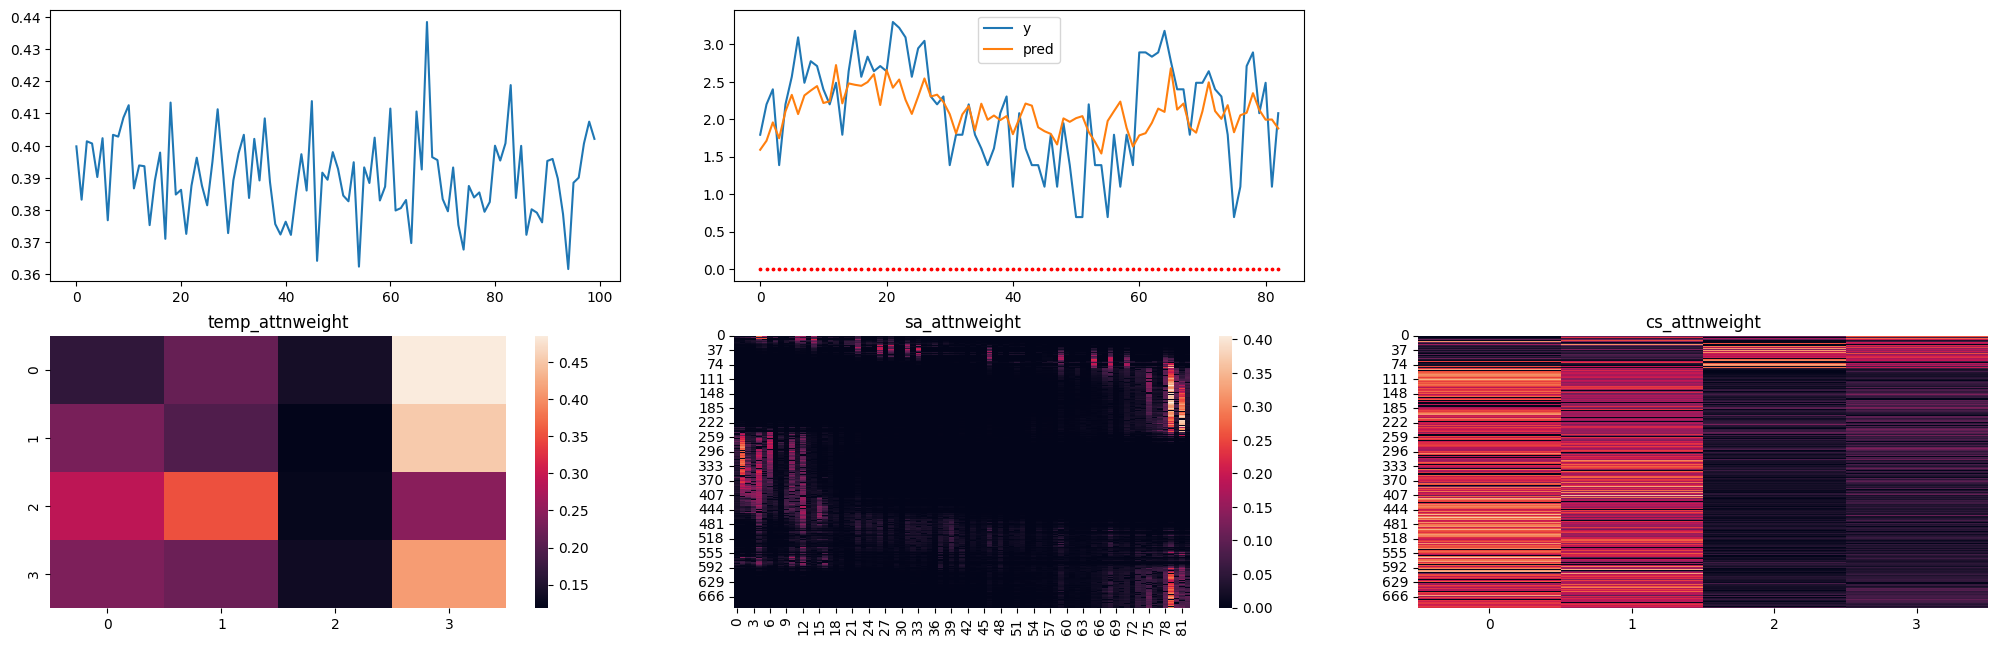

2 - num_loss: 0.3821813914179802, cat_loss: 0.007578100841492415, lr: 0.0009603999999999999: 100%|██████████| 587/587 [02:44<00:00,  3.58it/s] 


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss(reduction="none")
l1_loss = torch.nn.L1Loss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
torch.autograd.set_detect_anomaly(False)

def loss_num_fn(pred, y, mask):
    # mask = torch.where(mask==1, 1, 0)
    mask = torch.where(mask==2, 0, 1)
    loss = mse_loss(pred, y)
    # loss = l1_loss(pred, y)
    loss = mask * loss
    loss = (loss.sum()/mask.sum())
    return torch.sqrt(loss)

def loss_cat_fn(pred, y, mask):
    bs, t = y.shape
    # mask = torch.where(mask==1, 1, 0)
    mask = torch.where(mask==2, 0, 1)
    pred = pred.flatten(0, 1)
    y = y.flatten(0, 1).to(torch.long)
    loss = ce_loss(pred, y).reshape(bs, t)
    loss = mask * loss
    loss = (loss.sum()/mask.sum())
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    # pbar = tqdm(valid_dataloader)
    loss_li, num_loss_li, cat_loss_li = [], [], []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, pred_cat, temp_attnweight, sa_attnweight, cs_attnweight = model(
                                                                    data["sales"].to(device), 
                                                                    data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                                                    data["mask"].to(device),
                                                                    )
        loss_num = loss_num_fn(pred, data["y"].to(device), data["mask"].to(device))
        loss_cat = loss_cat_fn(pred_cat, data["y_cat"].to(device), data["mask"].to(device))
        loss = loss_num + loss_cat
        loss.backward()
        optimizer.step()

        loss_li.append(loss.item()); num_loss_li.append(loss_num.item()); cat_loss_li.append(loss_cat.item())
        pbar.set_description(f"{e} - num_loss: {np.mean(num_loss_li[-window:])}, cat_loss: {np.mean(cat_loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")

        if n % 20 == 0:
            plt.figure(figsize=(25,12))
            nrows, ncols = 3, 3
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            length = data["length"][-1]
            plt.subplot(nrows, ncols, 2)
            plt.plot(data["y"][-1][:length], label="y")
            plt.plot(pred[-1][:length].detach().cpu(), label="pred")
            plt.scatter(np.arange(data["mask"][-1][:length].shape[0]), torch.where(data["mask"][-1]==1, 0, np.nan)[:length], color="red", s=3)
            plt.legend()

            # Attn
            plt.subplot(nrows, ncols, 4)
            sns.heatmap(temp_attnweight[-1].mean(dim=0).detach().cpu())
            plt.title("temp_attnweight")

            plt.subplot(nrows, ncols, 5)
            sns.heatmap(sa_attnweight[-1].mean(dim=0).detach().cpu()[:, :length])
            plt.title("sa_attnweight")

            plt.subplot(nrows, ncols, 6)
            sns.heatmap(cs_attnweight[-1].squeeze().detach().cpu(), cbar=False)
            plt.title("cs_attnweight")

            plt.show()

epoch = 3
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

tensor([2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)


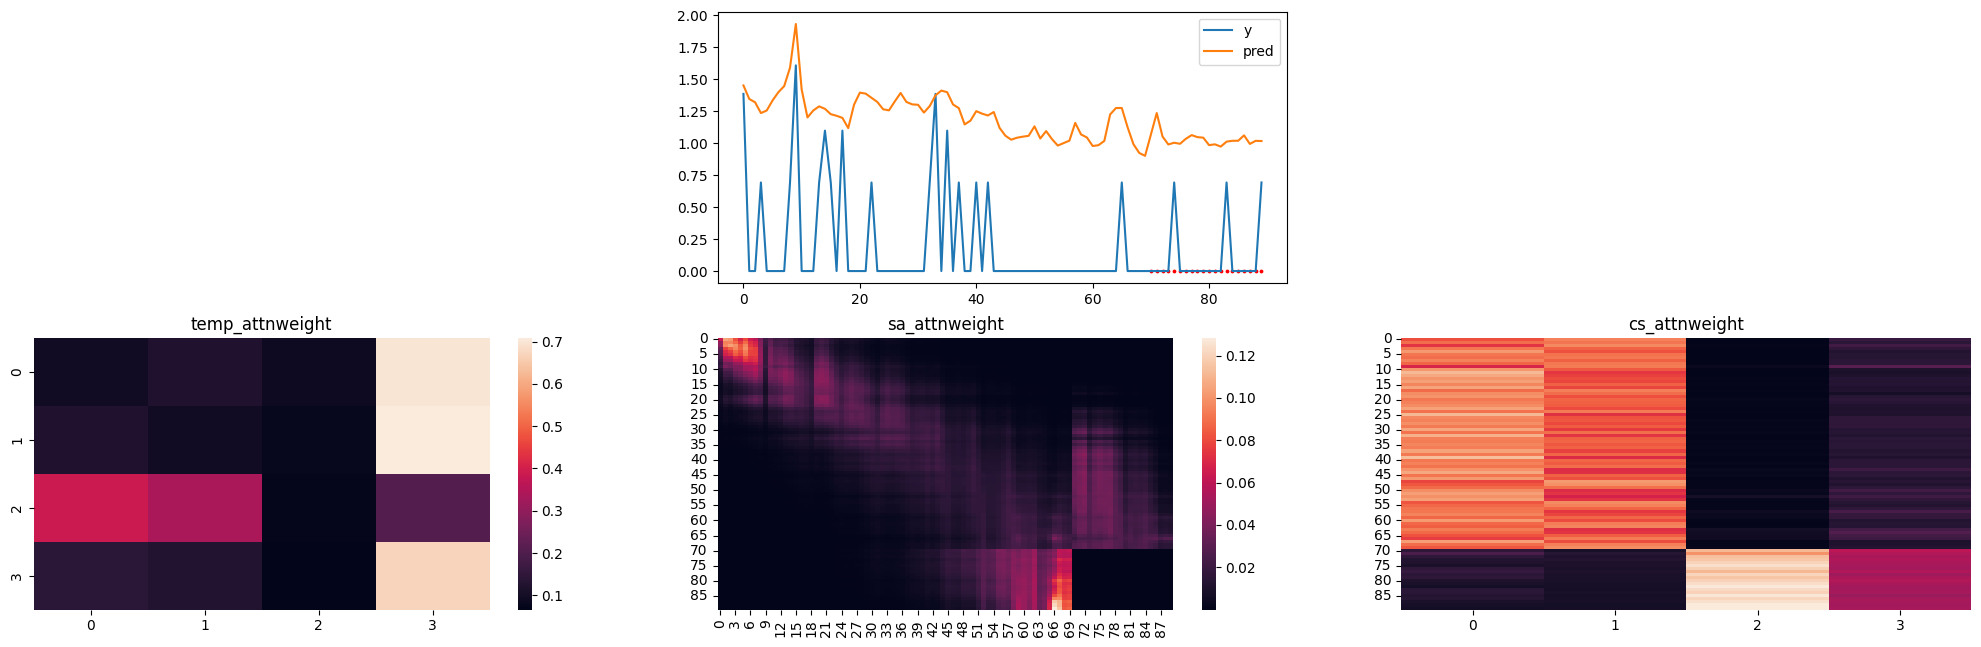

  4%|▍         | 24/587 [01:48<42:31,  4.53s/it]


KeyboardInterrupt: Interrupted by user

In [13]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        sales = data["sales"].to(device)
        mask = data["mask"].to(device)
        pred, pred_cat, temp_attnweight, sa_attnweight, cs_attnweight = model(
                                                                                data["sales"].to(device), 
                                                                                data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                                                                data["mask"].to(device),
                                                                                )

        # for i in range(30):
        #     pred, pred_cat, temp_attnweight, sa_attnweight, cs_attnweight = model(
        #                                                                             data["sales"].to(device), 
        #                                                                             data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        #                                                                             data["mask"].to(device),
        #                                                                             )
            # idx = torch.argmax(mask, -1)
            # for n, i in enumerate(idx):
            #     sales[n, i] = pred[n, i]
            #     mask[n, i] = 0
        
        plt.figure(figsize=(25,12))
        nrows, ncols = 3, 3
        clear_output(wait=True)

        print(torch.argmax(pred_cat, dim=-1)[-1])
        print(data["y_cat"][-1])

        # Sample
        length = data["length"][-1]
        plt.subplot(nrows, ncols, 2)
        plt.plot(data["y"][-1], label="y")
        plt.plot(pred[-1].detach().cpu(), label="pred")
        # plt.scatter(np.arange(data["mask"][-1][:length].shape[0]), torch.where(data["mask"][-1]==0, np.nan, 0)[:length], color="red", s=3)
        plt.scatter(np.arange(data["mask"][-1].shape[0]), torch.where(data["mask"][-1]==0, np.nan, 0), color="red", s=3)
        plt.legend()

        # Attn
        plt.subplot(nrows, ncols, 4)
        sns.heatmap(temp_attnweight[-1].mean(dim=0).detach().cpu())
        plt.title("temp_attnweight")

        plt.subplot(nrows, ncols, 5)
        sns.heatmap(sa_attnweight[-1].mean(dim=0).detach().cpu()[:, :length])
        plt.title("sa_attnweight")

        plt.subplot(nrows, ncols, 6)
        sns.heatmap(cs_attnweight[-1].squeeze().detach().cpu(), cbar=False)
        plt.title("cs_attnweight")

        plt.show()
        input()